141
16
    Year  Wheat and products  Rice (Milled Equivalent)  Barley and products  \
0   1961            0.024905                  0.000000             0.723394   
1   1962            0.007407                  0.049786             0.685488   
2   1963            0.000000                  0.019807             0.699128   
3   1964            0.042635                  0.044433             0.761301   
4   1965            0.156606                  0.074411             0.574782   
5   1966            0.097954                  0.057816             0.619667   
6   1967            0.028747                  0.069593             0.606820   
7   1968            0.185214                  0.087794             0.681840   
8   1969            0.228914                  0.114561             0.754322   
9   1970            0.230534                  0.045503             0.885646   
10  1971            0.321868                  0.093148             0.815543   
11  1972            0.247338                 

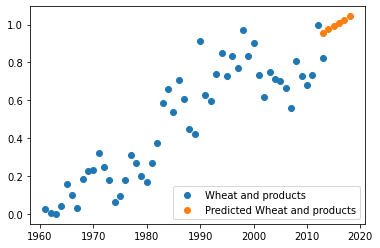

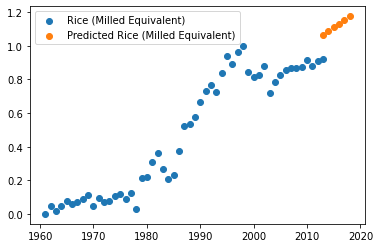

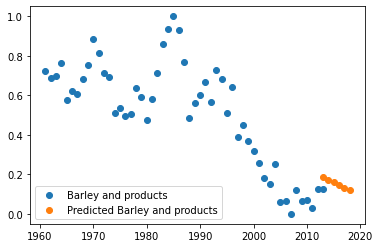

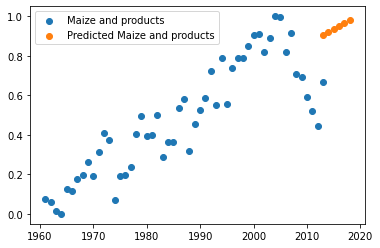

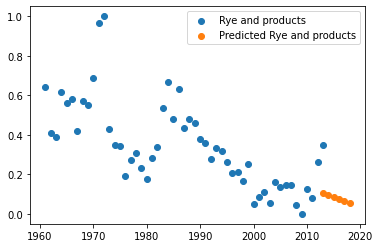

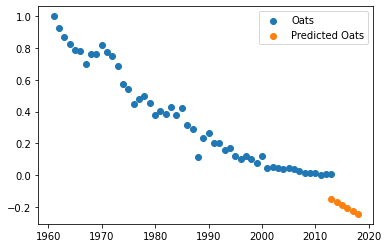

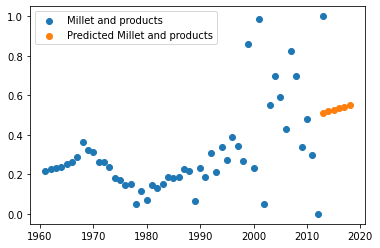

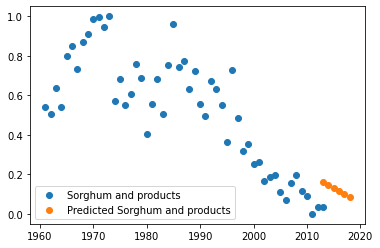

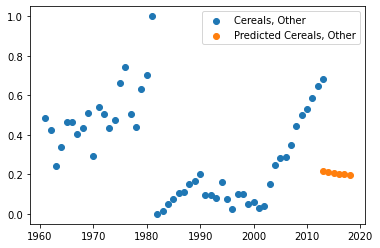

Scale is [4.629201e-05]

2013 Predicted Amount:
[20691.79022251]

2013 Real Amount:
[17840.]

2018 Predicted Amount:
[22927.05688414]

Real Bushels:
1885156000

Real Kilograms:
51276243200.0

Real Metric Tonnes (100tonnes unit):
51276243.2
21477
2330
           Area  Area Code                      Item  Item Code   Y1994  \
0   Afghanistan          2       Barley and products       2513   189.0   
1   Afghanistan          2            Cereals, Other       2520     0.0   
2   Afghanistan          2        Maize and products       2514   439.0   
3   Afghanistan          2       Millet and products       2517    20.0   
4   Afghanistan          2  Rice (Milled Equivalent)       2805   260.0   
5   Afghanistan          2        Wheat and products       2511  1855.0   
6       Albania          3       Barley and products       2513     8.0   
7       Albania          3            Cereals, Other       2520     0.0   
8       Albania          3        Maize and products       2514   174.0   

In [1]:
from sklearn.naive_bayes import MultinomialNB;
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
from sklearn import preprocessing;
from sklearn.manifold import MDS;
from sklearn.decomposition import PCA;
from sklearn.cluster import KMeans;
from sklearn.mixture import GaussianMixture;
from sklearn.model_selection import train_test_split;
from IPython.display import Image;
import pydotplus;
from copy import deepcopy;
from sklearn.neighbors import KNeighborsClassifier;
from sklearn.metrics import confusion_matrix;
from sklearn.tree import DecisionTreeClassifier;
from sklearn.tree._tree import TREE_LEAF;
from sklearn import tree as treeDep;
import seaborn as sn;
from sklearn.metrics import plot_confusion_matrix;
from DataProcessing import DataProcessing;
from sklearn.linear_model import LinearRegression;


# Problem 1, Linear Regression of USAFAO for total wheat production 2013-2019

cereal_types = [
    "Wheat", "Rice", "Barley", "Maize", "Rye", "Oats", "Millet", "Sorghum", "Cereals, Other"]

cereal_codes = [
    2511, 2805, 2513, 2514, 2515, 2516, 2517, 2518, 2520]


# Import USAFAO
USAFAO_data = pd.read_csv("USAFAO.csv")

# Clean up data
cleaned_USAFAO = DataProcessing.cleanDF(cereal_codes, 'Item Code', USAFAO_data)

print(len(USAFAO_data['Item']))
print(len(cleaned_USAFAO['Item']))

# Prepare data to for merging of feed and food
drop_array = ['Area Abbreviation', 'Area','Area Code', 'Element Code', 'Element', 'Unit', 'latitude', 'longitude']
grouped_USAFAO = cleaned_USAFAO.drop(drop_array, axis = 1)
grouped_USAFAO = grouped_USAFAO.groupby(['Item','Item Code']).sum().reset_index()

grouped_USAFAO = grouped_USAFAO.drop(['Item Code'], axis=1)
grouped_USAFAO = grouped_USAFAO.rename(index=grouped_USAFAO['Item']).drop("Item", axis=1)
# print(grouped_USAFAO.head(2))
x_train, x_test, y_train, y_test = train_test_split(grouped_USAFAO.drop("Y2013", axis=1),grouped_USAFAO['Y2013'], random_state=42, test_size=.35 )

reg = LinearRegression()
min_max_scaler = preprocessing.MinMaxScaler()

reFormattedDF = pd.DataFrame(data={"Year":map(lambda num: num+1961, range(2014-1961))});
for cereal in dict.fromkeys(cleaned_USAFAO['Item']).keys():
    tempDF = deepcopy(grouped_USAFAO)
    tempDF = tempDF.loc[cereal]
    x_scaled = min_max_scaler.fit_transform(tempDF.values.reshape(-1, 1))
    if(cereal == 'Wheat and products'):
        saved_scale =  min_max_scaler.scale_
    baseDF = pd.DataFrame(x_scaled, columns =[cereal])
#     baseDF = pd.DataFrame(data={cereal:normalized})
#     baseDF = pd.DataFrame(data={cereal:tempDF.values})
    reFormattedDF = reFormattedDF.join(baseDF[cereal])

print(reFormattedDF)

x_train, x_test, y_train, y_test = train_test_split(reFormattedDF['Year'].values.reshape(-1, 1),reFormattedDF.drop("Year",axis=1), random_state=42, test_size=.22 )


reg.fit(x_train, y_train)

errRateTrain = reg.score(x_train,y_train)
errRateTest =  reg.score(x_test,y_test)

print("Error on training {:.3f}".format(errRateTrain))
print("Error on testing {:.3f}\n".format(errRateTest))

x = np.array(list(map(lambda num: num+2013, range(2020-2014))))
y = reg.predict(np.array(list(map(lambda num: num+2013, range(2020-2014)))).reshape(-1, 1))
print((x).shape)
print((y).shape)



for i in range(len(reFormattedDF.columns)-1):
    plt.scatter(reFormattedDF['Year'], reFormattedDF.drop('Year',axis=1).values[:,i], label=reFormattedDF.drop('Year',axis=1).columns[i])
    plt.scatter(x, y[:,i], label="Predicted " + reFormattedDF.drop('Year',axis=1).columns[i])
    plt.legend()
    plt.show()
    
print("Scale is {}\n".format(saved_scale))
print("2013 Predicted Amount:")
print(reg.predict(np.array([2013]).reshape(-1,1))[0][0]/saved_scale)
print("\n2013 Real Amount:")
print(reFormattedDF["Wheat and products"].values[-1]/saved_scale)
pred2018 = reg.predict(np.array([2019]).reshape(-1,1))[0][0]/saved_scale
print("\n2018 Predicted Amount:")
print(pred2018)

print("\nReal Bushels:")
print((1885156 *1000))

print("\nReal Kilograms:")
print((1885156 * 1000 * 27.2 ))

print("\nReal Metric Tonnes (100tonnes unit):")
print(((1885156 * 1000* 27.2) / 1000))
    
#--------------------------
# Problem 2

# Clean up data
cleaned_FAO = DataProcessing.cleanDF(cereal_codes, 'Item Code', USAFAO_data)

# Prepare data to for merging of feed and food
drop_array = ['Area','Area Code','Area Abbreviation', 'Element Code', 'Element', 'Unit', 'latitude', 'longitude']
grouped_FAO = cleaned_FAO.drop(drop_array, axis = 1)
grouped_FAO = grouped_FAO.groupby(['Item','Item Code',]).sum().reset_index()

# Create Yield over last 20 years column
mean_USAFAO = DataProcessing.dropYears(grouped_FAO, 20, 2013)
mean_USAFAO = DataProcessing.yieldAvg(mean_USAFAO)

# print(mean_FAO.head(20))

# Problem 3

# Import FAO
FAO_data = pd.read_csv("FAO.csv",encoding='latin1')

# Clean up data
cleaned_FAO = DataProcessing.cleanDF(cereal_codes, 'Item Code', FAO_data)

print(len(FAO_data['Item']))
print(len(cleaned_FAO['Item']))

# Prepare data to for merging of feed and food
drop_array = ['Area Abbreviation', 'Element Code', 'Element', 'Unit', 'latitude', 'longitude']
grouped_FAO = cleaned_FAO.drop(drop_array, axis = 1)
grouped_FAO = grouped_FAO.groupby(['Area','Area Code','Item','Item Code',]).sum().reset_index()
# print(grouped_FAO.head(20))

# Create Yield over last 20 years column
mean_FAO = DataProcessing.dropYears(grouped_FAO, 20, 2013)
mean_FAO = DataProcessing.yieldAvg(mean_FAO)

print(mean_FAO.head(20))




                                   Area  Barley and products  Cereals, Other  \
0                           Afghanistan               257.35            0.25   
1                               Albania                 5.60            0.70   
2                               Algeria              1065.70            4.70   
3                                Angola                 0.00            0.00   
4                   Antigua and Barbuda                 0.00            0.00   
..                                  ...                  ...             ...   
169  Venezuela (Bolivarian Republic of)                 4.25           17.70   
170                            Viet Nam                 0.00            1.25   
171                               Yemen                32.95            2.50   
172                              Zambia                 0.00            0.30   
173                            Zimbabwe                 6.75            3.40   

     Maize and products  Millet and pro

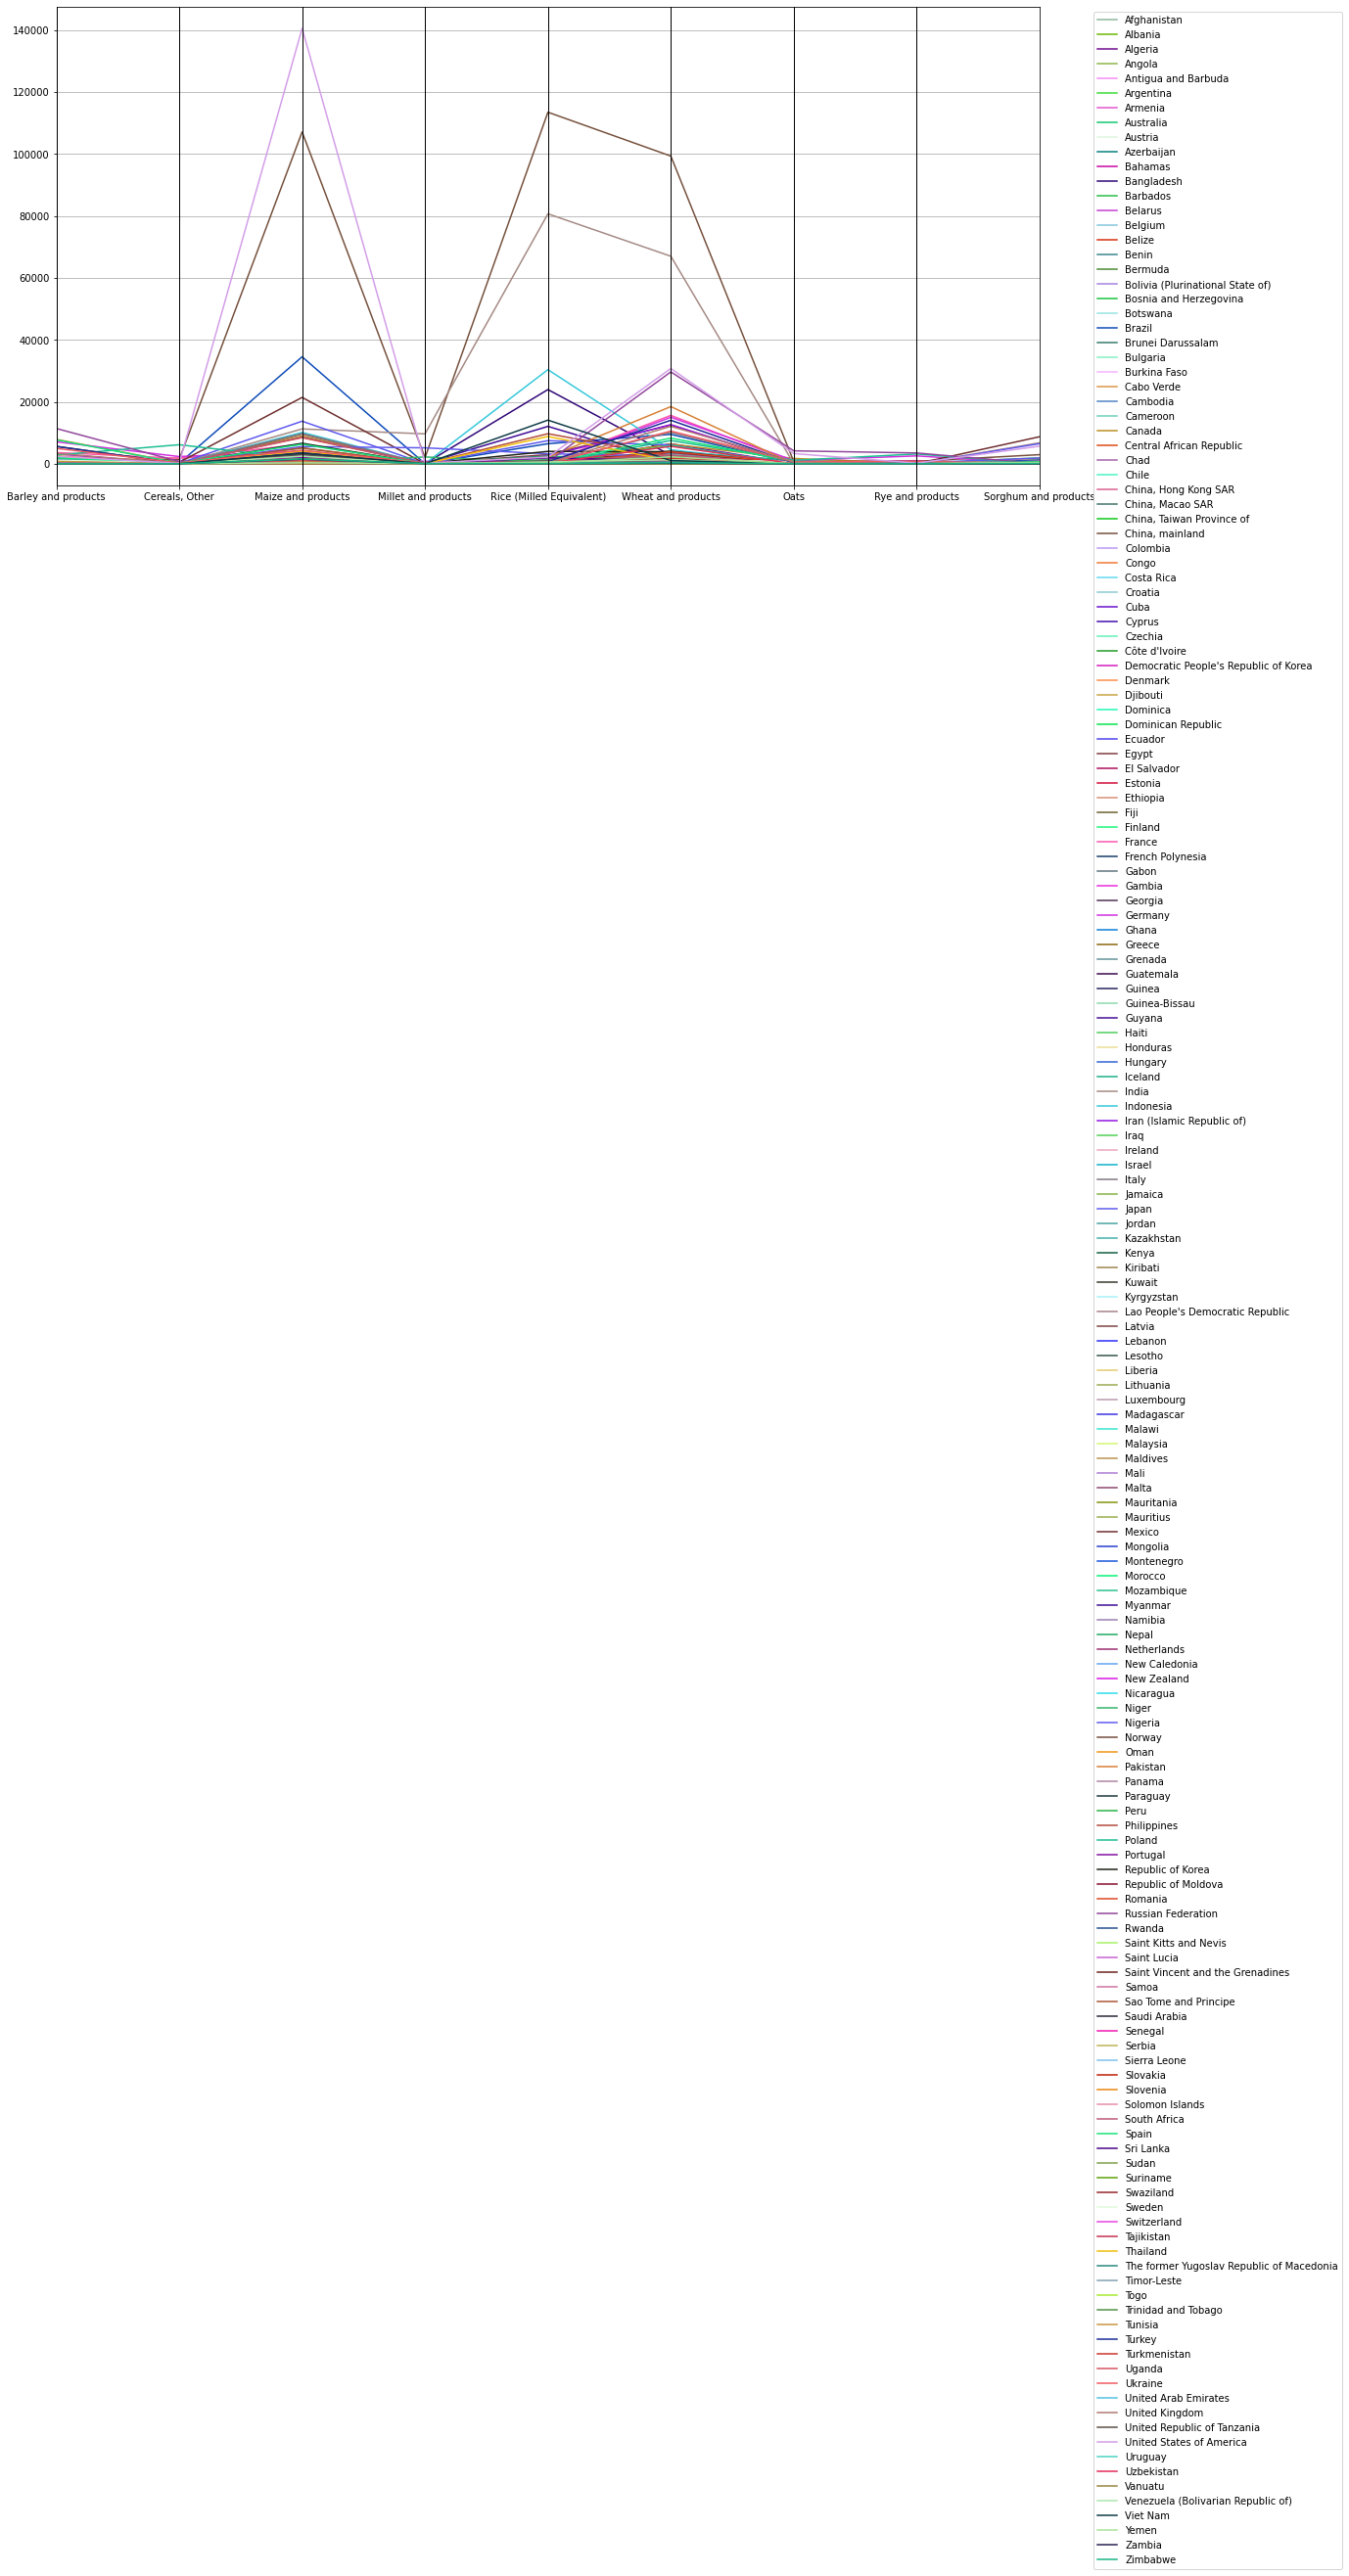

Normalized Table 

                                   Area  Barley and products  Cereals, Other  \
0                           Afghanistan             0.022617        0.000041   
1                               Albania             0.000492        0.000114   
2                               Algeria             0.093660        0.000767   
3                                Angola             0.000000        0.000000   
4                   Antigua and Barbuda             0.000000        0.000000   
..                                  ...                  ...             ...   
169  Venezuela (Bolivarian Republic of)             0.000374        0.002888   
170                            Viet Nam             0.000000        0.000204   
171                               Yemen             0.002896        0.000408   
172                              Zambia             0.000000        0.000049   
173                            Zimbabwe             0.000593        0.000555   

     Maize and produ

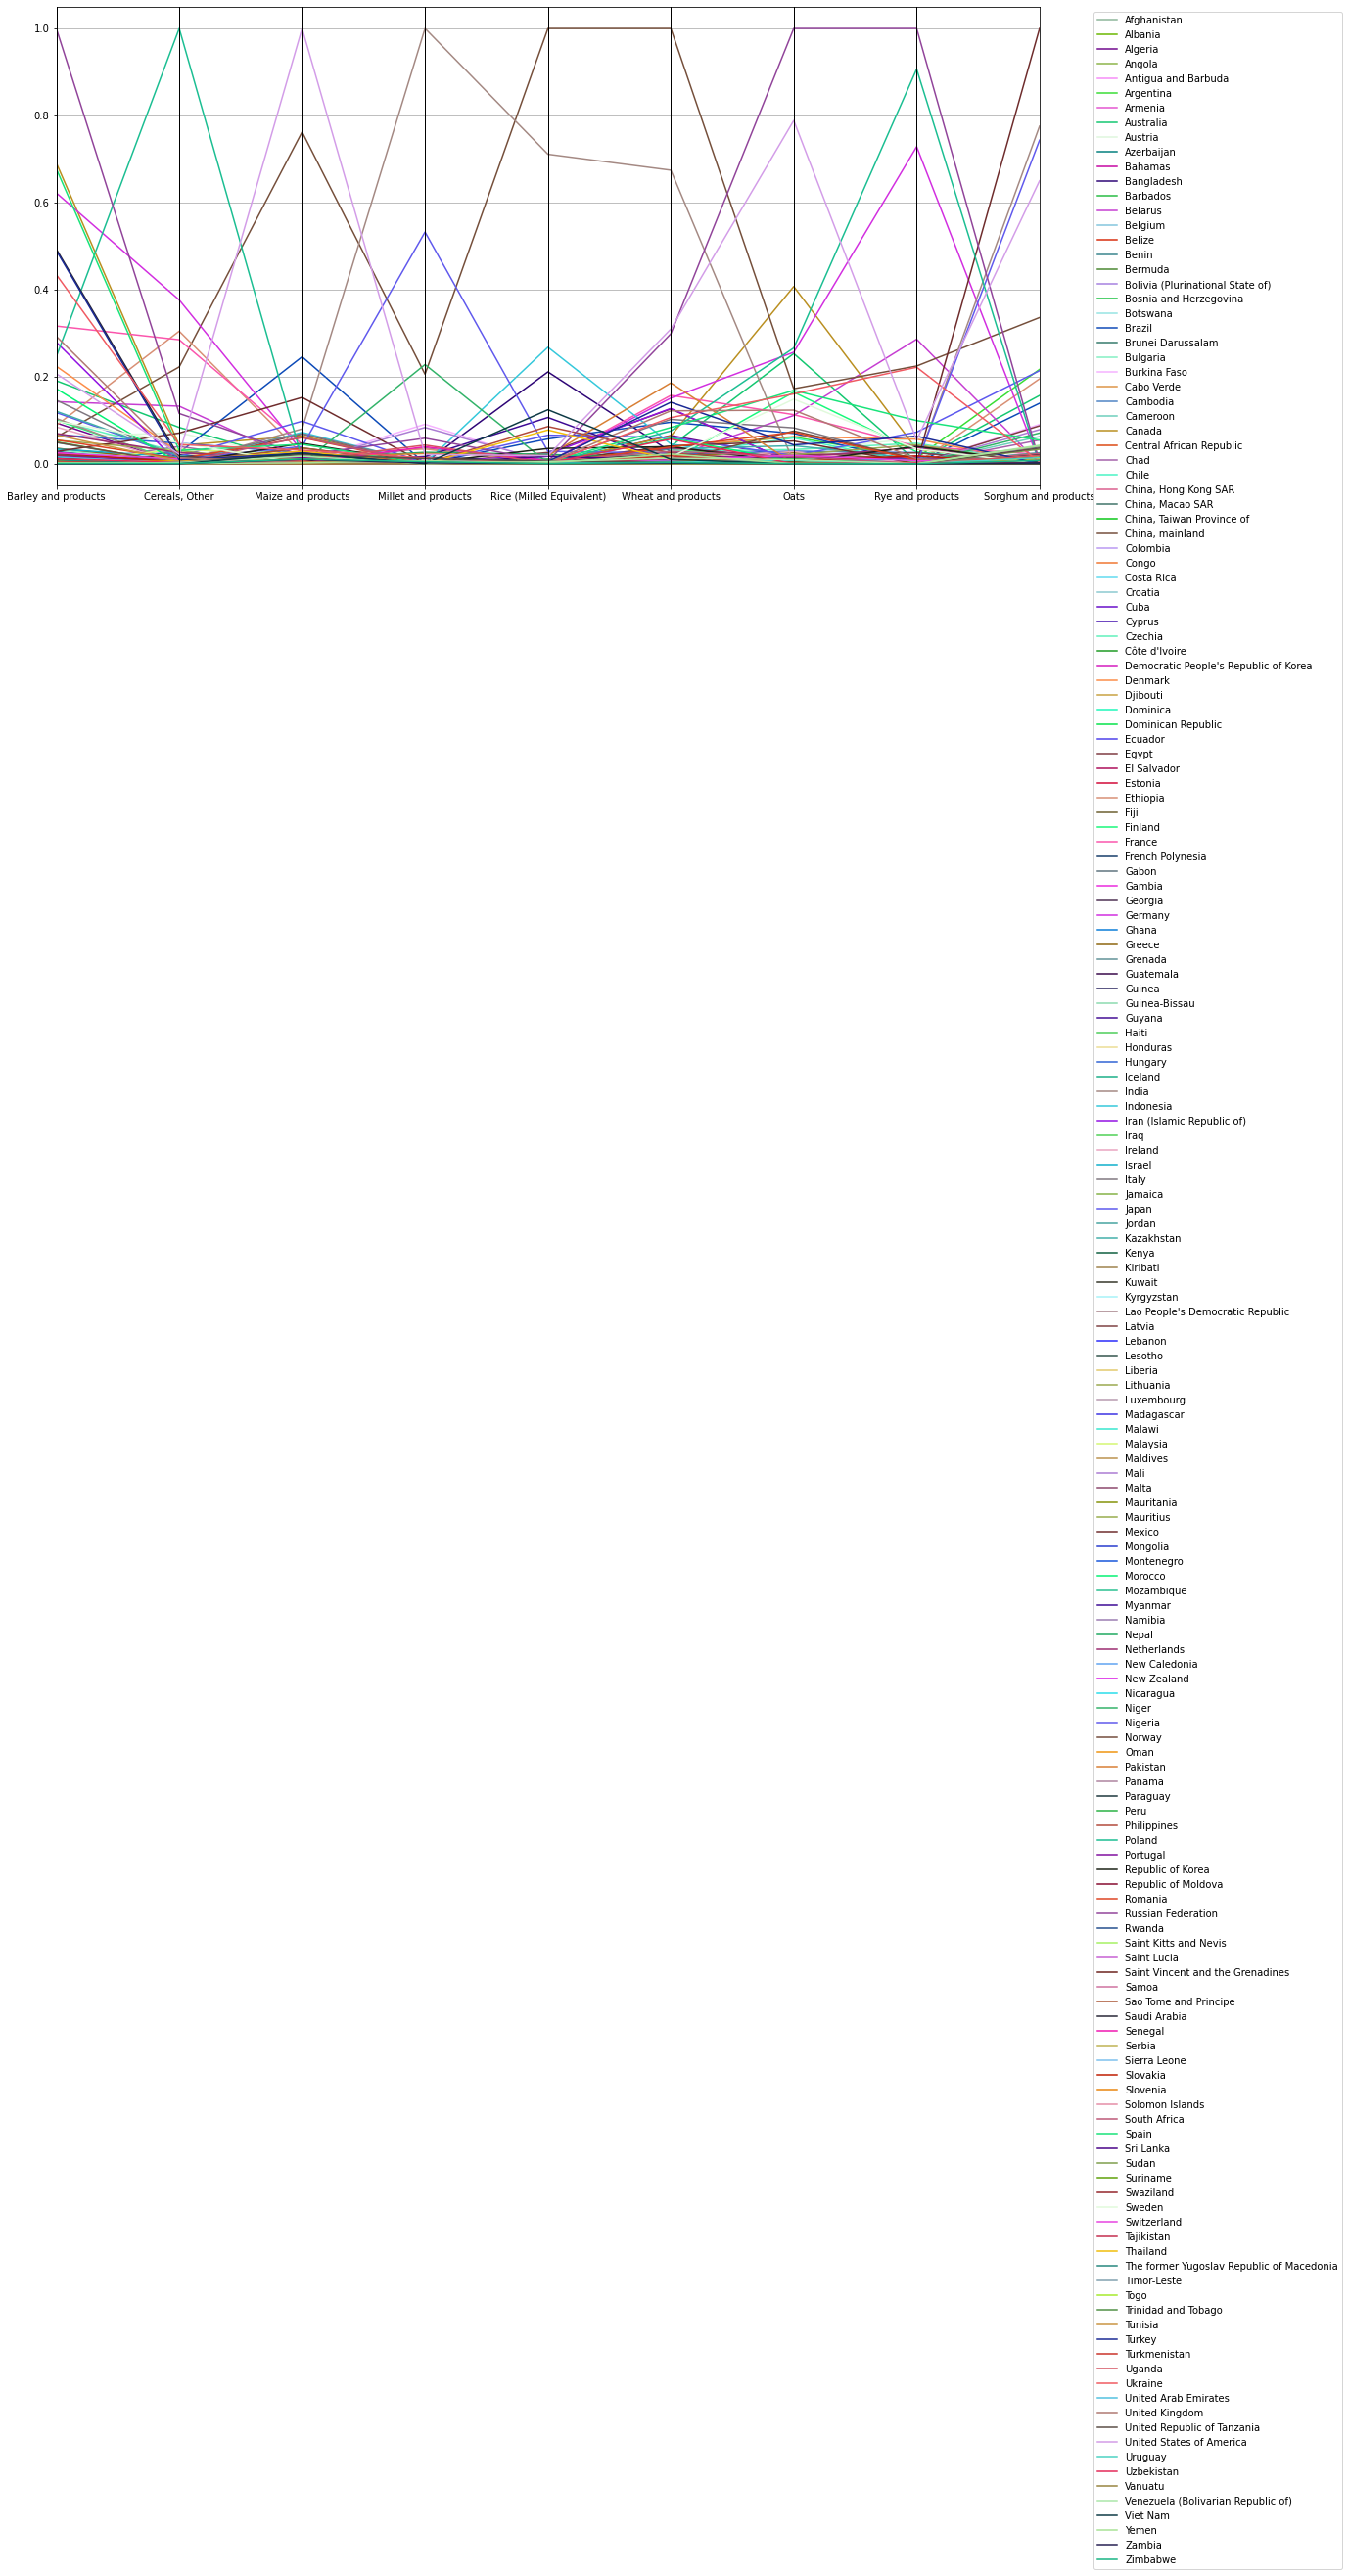

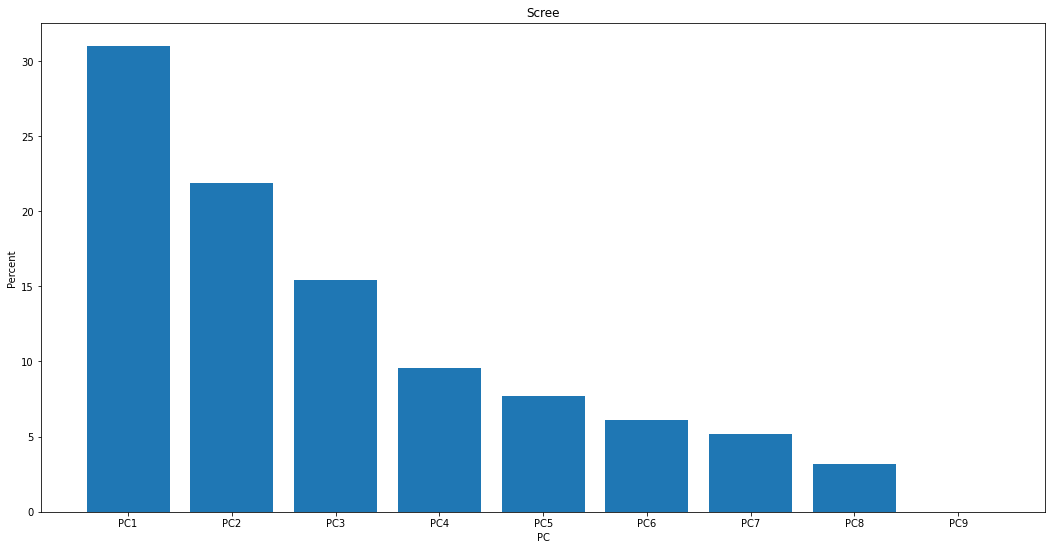

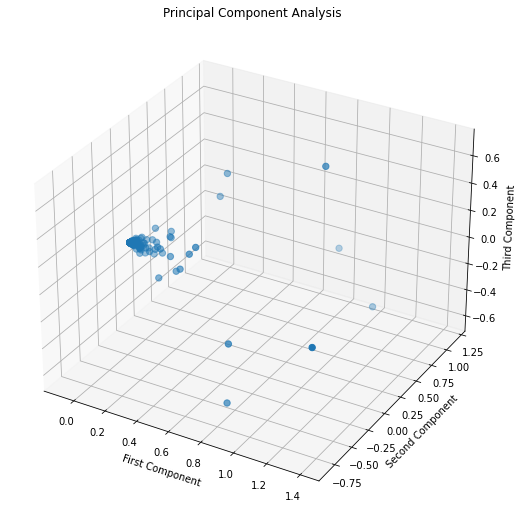

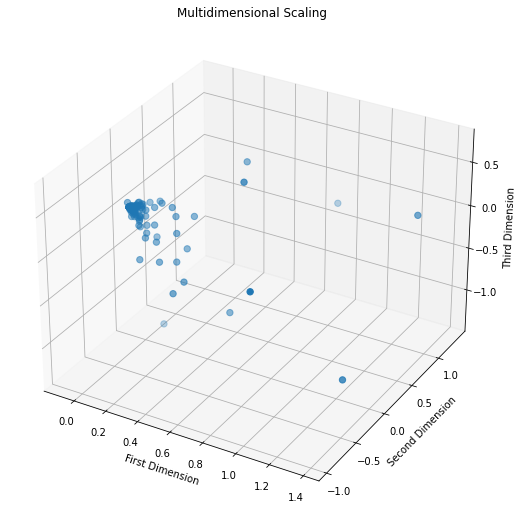

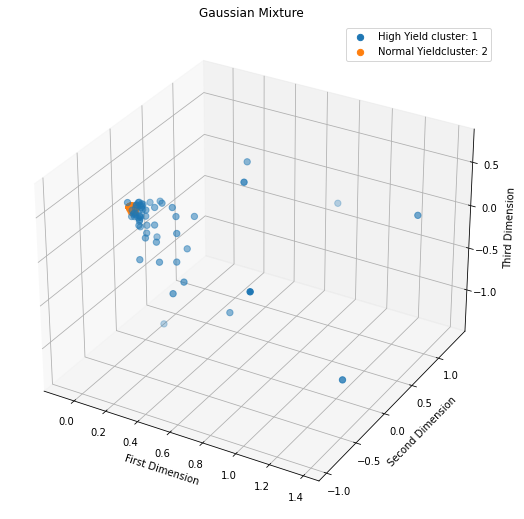

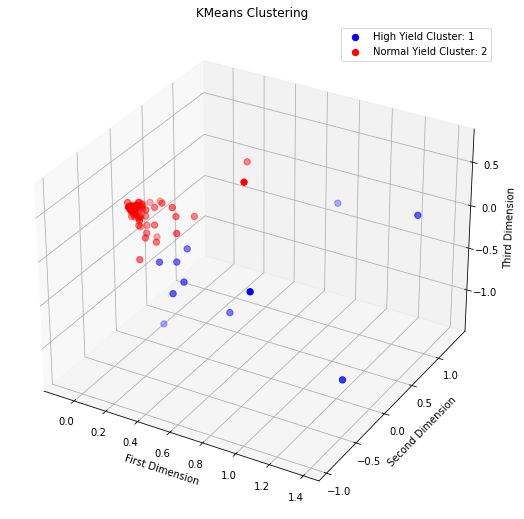

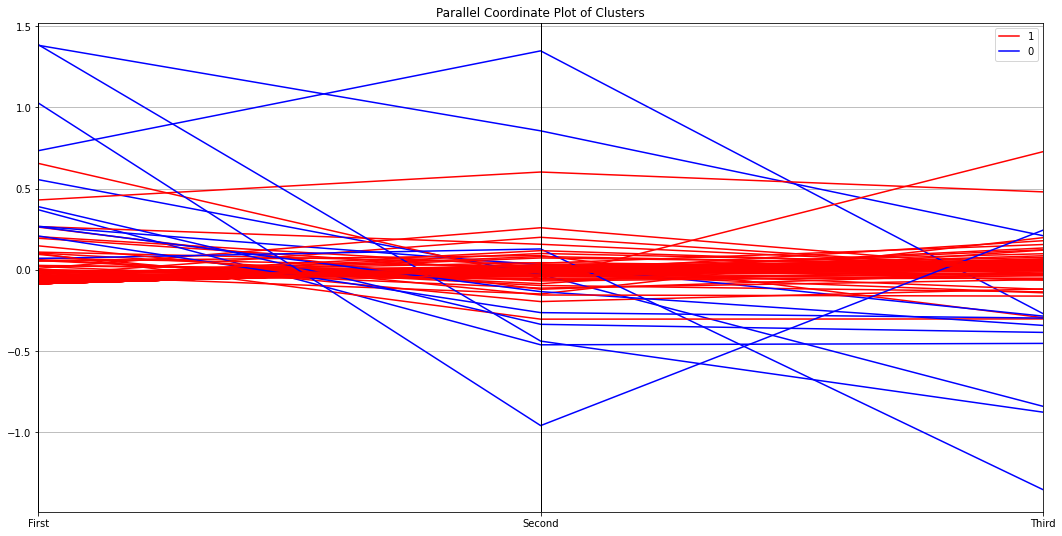

In [2]:
# Problem 4 Data Exploration

#Set up data for parallel coordinates (Column of Countries, Columns of cerals, cells of YA)
dict_cereals = dict.fromkeys(mean_FAO['Item'])

parallel_FAO = mean_FAO[mean_FAO['Area']=="Null"]['Area'].to_frame()
key_col = "Area"

unique_areas = dict.fromkeys(mean_FAO['Area']).keys()
count = 0

for key in unique_areas:

    parallel_FAO = DataProcessing.parallel(mean_FAO, parallel_FAO, key, dict_cereals, key_col)

# Parallel Coordinates of Ceral vs average yield
xTicks = list(dict_cereals.keys())
xTicks.append("Area")

plt.rcParams['figure.figsize'] = [len(cereal_types)*2, len(cereal_types)]
pd.plotting.parallel_coordinates(parallel_FAO[xTicks], 'Area')
plt.legend(bbox_to_anchor=(1.05, 1))
print(parallel_FAO)
plt.show()

# Normalize Data

min_max_scaler = preprocessing.MinMaxScaler()

norm_FAO = deepcopy(parallel_FAO)

for cereal in xTicks[0:len(xTicks)-1]:
    x_scaled = min_max_scaler.fit_transform(parallel_FAO[cereal].values.reshape(-1, 1))
    temp_df = pd.DataFrame(x_scaled, columns =[cereal])
    norm_FAO.update(temp_df)

print("Normalized Table \n")
print(norm_FAO)
pd.plotting.parallel_coordinates(norm_FAO[xTicks], 'Area')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

# Scree Plot
focused_data = norm_FAO.drop('Area', axis=1)
scaled_data = preprocessing.scale(focused_data.T.values)
pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percent')
plt.xlabel("PC")
plt.title("Scree")
plt.show()

# Run PCA on the data

unique_areas_reduced = dict.fromkeys(norm_FAO['Area']).keys()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
mds_array=[]
focused_data = norm_FAO.drop('Area', axis=1)
emb = PCA(3, random_state=42)
fitted_x = emb.fit_transform(focused_data.values)
mds_array.append(fitted_x)    
ax.scatter(fitted_x[:,0],fitted_x[:,1],fitted_x[:,2], s=40)

# plt.legend(bbox_to_anchor=(1.05, 1))
ax.set_xlabel("First Component")
ax.set_ylabel("Second Component")
ax.set_zlabel("Third Component")
plt.title("Principal Component Analysis")


plt.show()  

# Run MDS on the data

unique_areas_reduced = dict.fromkeys(norm_FAO['Area']).keys()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
mds_array=[]
focused_data = norm_FAO.drop('Area', axis=1)
emb = MDS(3, random_state=26)
fitted_x = emb.fit_transform(focused_data.values)
mds_array.append(fitted_x)    
ax.scatter(fitted_x[:,0],fitted_x[:,1],fitted_x[:,2], s=40)

# plt.legend(bbox_to_anchor=(1.05, 1))
ax.set_xlabel("First Dimension")
ax.set_ylabel("Second Dimension")
ax.set_zlabel("Third Dimension")
plt.title("Multidimensional Scaling")


plt.show()  

# Run GM on the data
fig = plt.figure(0)
ax = fig.add_subplot(111, projection='3d')

for i in range(len(mds_array)):
    focused_data = mds_array[i]
    grp = GaussianMixture(2, random_state=31)
    grp.fit(focused_data)
    yhat = grp.predict(focused_data)
    clusters = np.unique(yhat)
    j = 1
    
    for cluster in clusters:
        row_ix = np.where(yhat == cluster)
        if(j == 1):
            name = "High Yield "
        else:
            name = "Normal Yield"
        ax.scatter(focused_data[row_ix,0],focused_data[row_ix,1],focused_data[row_ix,2], s=40, label = name + "cluster: {}".format(j))      
        
        j+=1

plt.legend()
ax.set_xlabel("First Dimension")
ax.set_ylabel("Second Dimension")
ax.set_zlabel("Third Dimension")
plt.title("Gaussian Mixture")

plt.show()    

# Run KMeans on the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
large_frame = pd.DataFrame(columns = ["First","Second","Third", "clusters"])

headers = list(dict_cereals.keys())
headers.append("clusters")
PC1 = pd.DataFrame(columns = headers)
PC2 = pd.DataFrame(columns = headers)
PC3 = pd.DataFrame(columns = headers)

for i in range(len(mds_array)):

    focused_data = mds_array[i]
    kmeans = KMeans(n_clusters=2, random_state=54)
    yhat = kmeans.fit_predict(focused_data)
    temp = focused_data
    temp = pd.DataFrame(temp,columns=["First","Second","Third"])
    temp['clusters'] = yhat

    df1 = temp[temp['clusters']==0]
    df2 = temp[temp['clusters']==1]
    
    set1 = norm_FAO[temp['clusters']==0]
    set2 = norm_FAO[temp['clusters']==1]
#     set3 = norm_FAO[temp['clusters']==2]
#     df4 = temp[temp['clusters']==3]
#     df5 = temp[temp['clusters']==4]
    
    ax.scatter(df1['First'],df1['Second'],df1['Third'],c="blue", s=40, label = 'High Yield Cluster: 1')
    ax.scatter(df2['First'],df2['Second'],df2['Third'],c="red", s=40, label = 'Normal Yield Cluster: 2')
#     ax.scatter(df3['First'],df3['Second'],df3['Third'],c="green", s=40, label = 'Cluster: 3')
#     ax.scatter(df4['First'],df4['Second'],df4['Third'],c="orange", s=40, label = 'Cluster: 4')
#     ax.scatter(df5['First'],df5['Second'],df5['Third'],c="cyan", s=40, label = 'Cluster: 5')
    large_frame=large_frame.append(temp, ignore_index=True)

plt.legend()
ax.set_xlabel("First Dimension")
ax.set_ylabel("Second Dimension")
ax.set_zlabel("Third Dimension")
plt.title("KMeans Clustering")

plt.show()  

# Run Parallel on the data
fig = plt.figure()
names = ("High Yield", "Low Yield")
pd.plotting.parallel_coordinates(large_frame, 'clusters', color=('blue','red'), sort_labels=True)

plt.legend()
ax.set_xlabel("First Dimension")
ax.set_ylabel("Second Dimension")
ax.set_zlabel("Third Dimension")
plt.title("Parallel Coordinate Plot of Clusters")

plt.show()  

Std Table 

                     Area  Barley and products  Cereals, Other  \
1                 Albania                 5.60            0.70   
3                  Angola                 0.00            0.00   
4     Antigua and Barbuda                 0.00            0.00   
6                 Armenia                73.20           12.30   
10                Bahamas                 2.15            0.85   
..                    ...                  ...             ...   
156   Trinidad and Tobago                 1.50            1.75   
162  United Arab Emirates               179.75            7.95   
168               Vanuatu                 0.00            0.15   
172                Zambia                 0.00            0.30   
173              Zimbabwe                 6.75            3.40   

     Maize and products  Millet and products  Rice (Milled Equivalent)  \
1                252.15                 0.00                     38.00   
3                674.25                66.65   

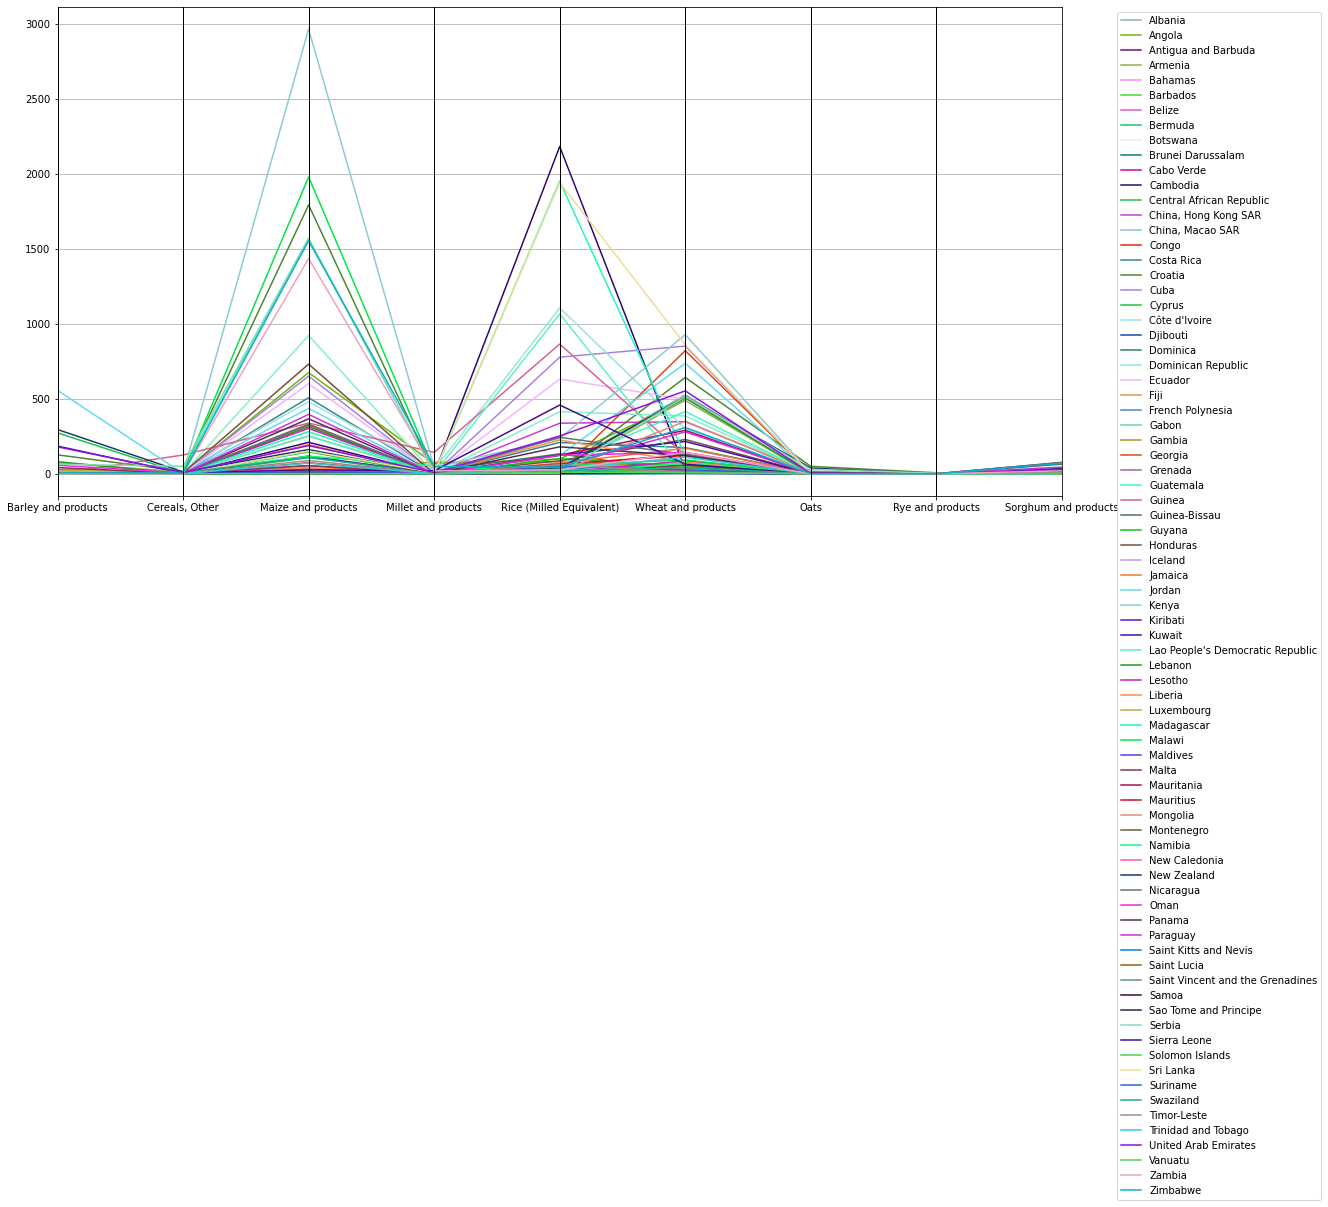

Normalized Table 

                     Area  Barley and products  Cereals, Other  \
1                 Albania             0.000000        0.000000   
3                  Angola             0.131690        0.098243   
4     Antigua and Barbuda             0.003868        0.006789   
6                 Armenia             0.000000        0.000000   
10                Bahamas             0.000000        0.004393   
..                    ...                  ...             ...   
156   Trinidad and Tobago             1.500000        1.750000   
162  United Arab Emirates           179.750000        7.950000   
168               Vanuatu             0.000000        0.150000   
172                Zambia             0.000000        0.300000   
173              Zimbabwe             6.750000        3.400000   

     Maize and products  Millet and products  Rice (Milled Equivalent)  \
1              0.227461             0.467391                  0.045210   
3              0.012280             0.00

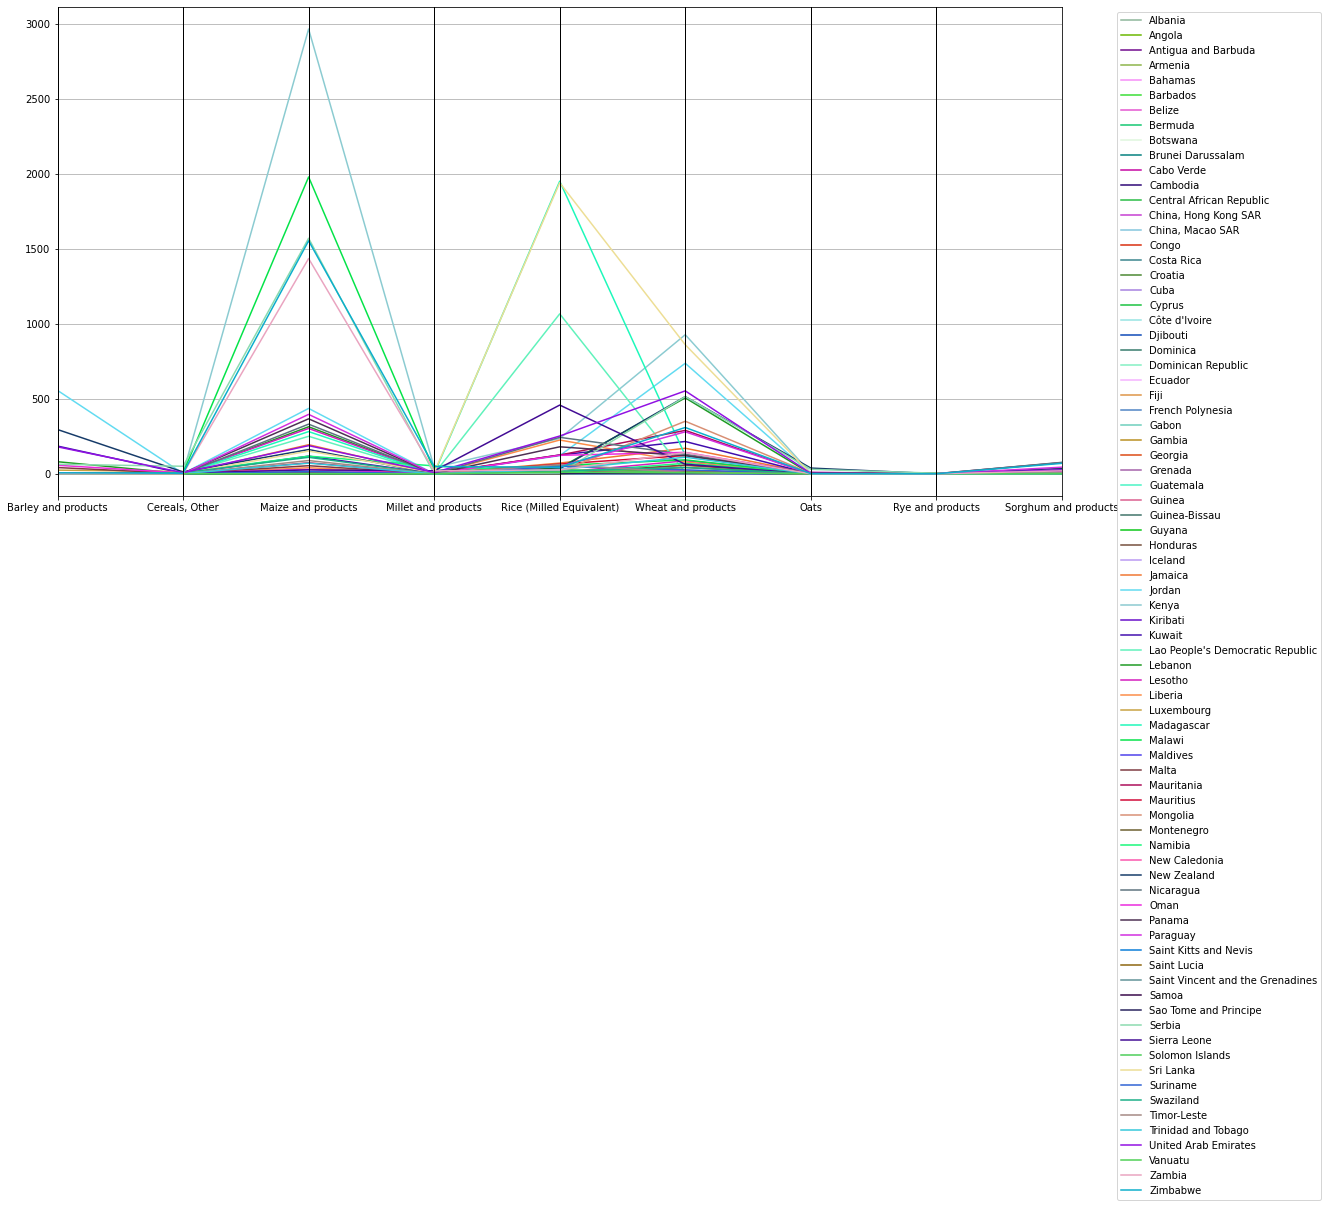

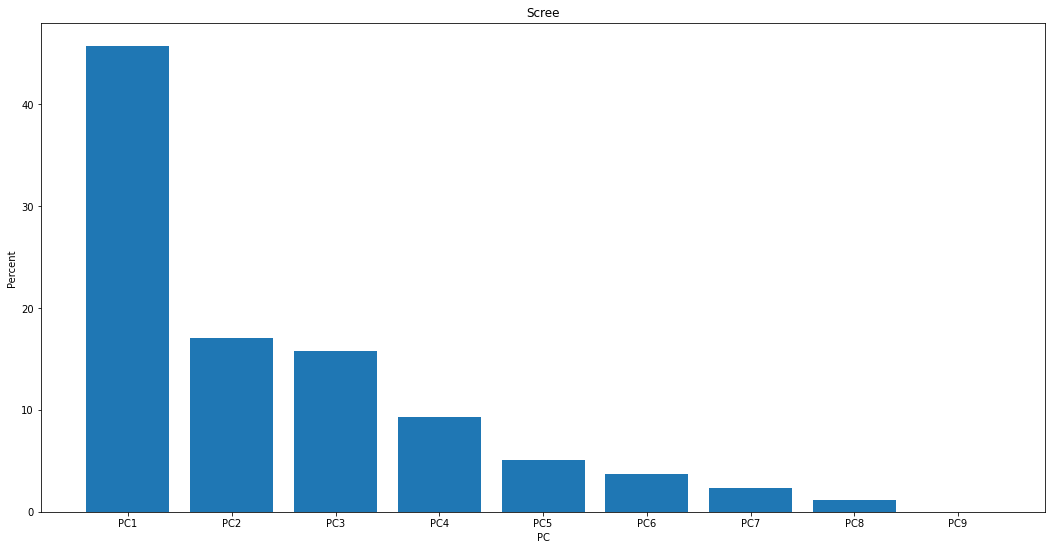

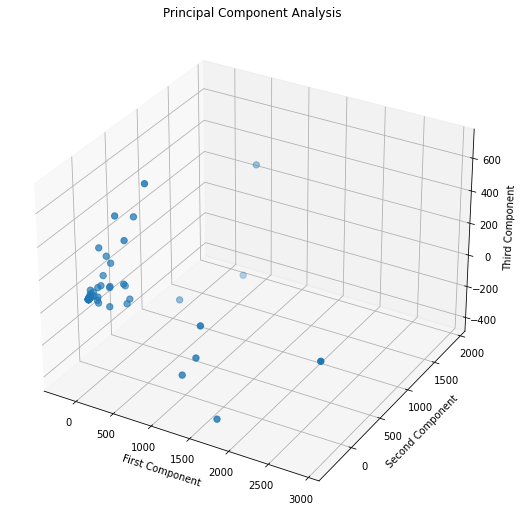

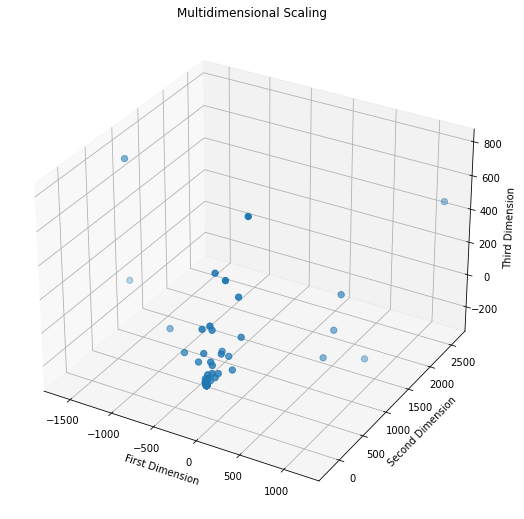

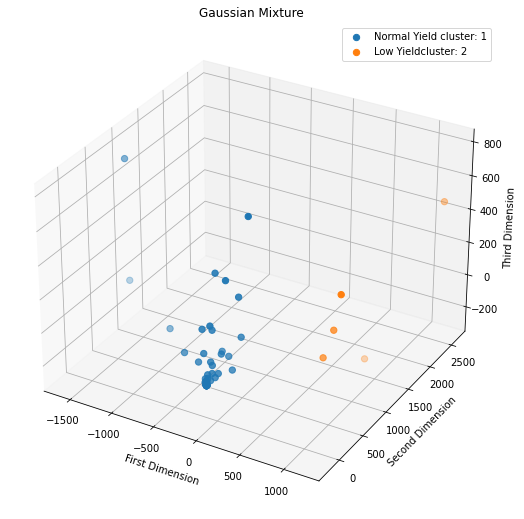

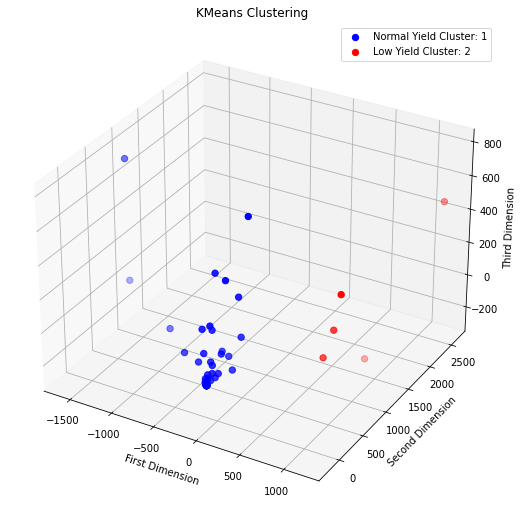

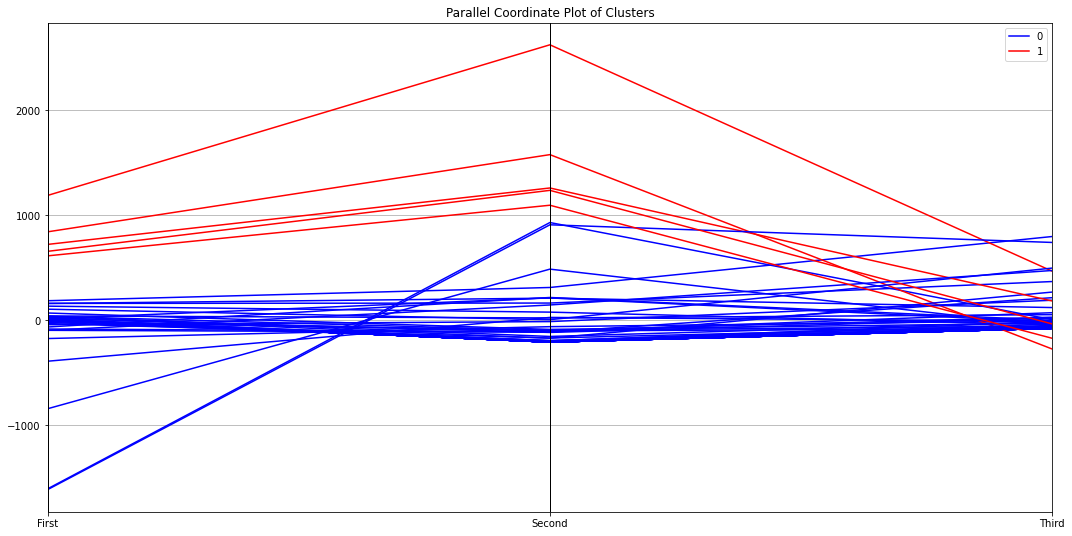

In [9]:
# Problem 5 Outlier Removal



#Set up data for parallel coordinates (Column of Countries, Columns of cerals, cells of YA)
dict_cereals = dict.fromkeys(mean_FAO['Item'])

parallel_FAO = mean_FAO[mean_FAO['Area']=="Null"]['Area'].to_frame()
key_col = "Area"

unique_areas = dict.fromkeys(mean_FAO['Area']).keys()
count = 0

for key in unique_areas:

    parallel_FAO = DataProcessing.parallel(mean_FAO, parallel_FAO, key, dict_cereals, key_col)


# Normalize Data
scaler = preprocessing.StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()

std_FAO = deepcopy(parallel_FAO)


for cereal in xTicks[0:len(xTicks)-1]:
    x_scaled = scaler.fit(std_FAO[cereal].values.reshape(-1, 1))
    std_FAO = std_FAO[np.array(list(map(lambda elem: elem <= (1*x_scaled.scale_), std_FAO[cereal].values))).reshape(-1,1)]
    

print("Std Table \n")
print(std_FAO)

pd.plotting.parallel_coordinates(std_FAO[xTicks], 'Area')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

norm_FAO = deepcopy(std_FAO)

for cereal in xTicks[0:len(xTicks)-1]:
    x_scaled = min_max_scaler.fit_transform(norm_FAO[cereal].values.reshape(-1, 1))
    temp_df = pd.DataFrame(x_scaled, columns =[cereal])
    norm_FAO.update(temp_df)

print("Normalized Table \n")
print(norm_FAO)
pd.plotting.parallel_coordinates(norm_FAO[xTicks], 'Area')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

# Scree Plot
focused_data = norm_FAO.drop('Area', axis=1)
scaled_data = preprocessing.scale(focused_data.T.values)
pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percent')
plt.xlabel("PC")
plt.title("Scree")
plt.show()

# Run PCA on the data

unique_areas_reduced = dict.fromkeys(norm_FAO['Area']).keys()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
mds_array=[]
focused_data = norm_FAO.drop('Area', axis=1)
emb = PCA(3, random_state=42)
fitted_x = emb.fit_transform(focused_data.values)
mds_array.append(fitted_x)    
ax.scatter(fitted_x[:,0],fitted_x[:,1],fitted_x[:,2], s=40)

# plt.legend(bbox_to_anchor=(1.05, 1))
ax.set_xlabel("First Component")
ax.set_ylabel("Second Component")
ax.set_zlabel("Third Component")
plt.title("Principal Component Analysis")


plt.show()  

# Run MDS on the data

unique_areas_reduced = dict.fromkeys(norm_FAO['Area']).keys()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
mds_array=[]
focused_data = norm_FAO.drop('Area', axis=1)
emb = MDS(3, random_state=26)
fitted_x = emb.fit_transform(focused_data.values)
mds_array.append(fitted_x)    
ax.scatter(fitted_x[:,0],fitted_x[:,1],fitted_x[:,2], s=40)

# plt.legend(bbox_to_anchor=(1.05, 1))
ax.set_xlabel("First Dimension")
ax.set_ylabel("Second Dimension")
ax.set_zlabel("Third Dimension")
plt.title("Multidimensional Scaling")


plt.show()  

# Run GM on the data
fig = plt.figure(0)
ax = fig.add_subplot(111, projection='3d')

for i in range(len(mds_array)):
    focused_data = mds_array[i]
    grp = GaussianMixture(2, random_state=31)
    grp.fit(focused_data)
    yhat = grp.predict(focused_data)
    clusters = np.unique(yhat)
    j = 1
    
    for cluster in clusters:
        row_ix = np.where(yhat == cluster)
        if(j == 1):
            name = "Normal Yield "
        else:
            name = "Low Yield"
        ax.scatter(focused_data[row_ix,0],focused_data[row_ix,1],focused_data[row_ix,2], s=40, label = name + "cluster: {}".format(j))      
        
        j+=1

plt.legend()
ax.set_xlabel("First Dimension")
ax.set_ylabel("Second Dimension")
ax.set_zlabel("Third Dimension")
plt.title("Gaussian Mixture")

plt.show()    

# Run KMeans on the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
large_frame = pd.DataFrame(columns = ["First","Second","Third", "clusters"])

headers = list(dict_cereals.keys())
headers.append("clusters")
PC1 = pd.DataFrame(columns = headers)
PC2 = pd.DataFrame(columns = headers)
PC3 = pd.DataFrame(columns = headers)

for i in range(len(mds_array)):

    focused_data = mds_array[i]
    kmeans = KMeans(n_clusters=2, random_state=54)
    yhat = kmeans.fit_predict(focused_data)
    temp = focused_data
    temp = pd.DataFrame(temp,columns=["First","Second","Third"])
    temp['clusters'] = yhat

    df1 = temp[temp['clusters']==0]
    df2 = temp[temp['clusters']==1]
    
#     set1 = norm_FAO[temp['clusters']==0]
#     set2 = norm_FAO[temp['clusters']==1]
#     set3 = norm_FAO[temp['clusters']==2]
#     df4 = temp[temp['clusters']==3]
#     df5 = temp[temp['clusters']==4]
    
    ax.scatter(df1['First'],df1['Second'],df1['Third'],c="blue", s=40, label = 'Normal Yield Cluster: 1')
    ax.scatter(df2['First'],df2['Second'],df2['Third'],c="red", s=40, label = 'Low Yield Cluster: 2')
#     ax.scatter(df3['First'],df3['Second'],df3['Third'],c="green", s=40, label = 'Cluster: 3')
#     ax.scatter(df4['First'],df4['Second'],df4['Third'],c="orange", s=40, label = 'Cluster: 4')
#     ax.scatter(df5['First'],df5['Second'],df5['Third'],c="cyan", s=40, label = 'Cluster: 5')
    large_frame=large_frame.append(temp, ignore_index=True)

plt.legend()
ax.set_xlabel("First Dimension")
ax.set_ylabel("Second Dimension")
ax.set_zlabel("Third Dimension")
plt.title("KMeans Clustering")

plt.show()  

# Run Parallel on the data
fig = plt.figure()
names = ("High Yield", "Low Yield")
pd.plotting.parallel_coordinates(large_frame, 'clusters', color=('blue','red'), sort_labels=True)

plt.legend()
ax.set_xlabel("First Dimension")
ax.set_ylabel("Second Dimension")
ax.set_zlabel("Third Dimension")
plt.title("Parallel Coordinate Plot of Clusters")

plt.show()  

         First       Second       Third  clusters
0     2.730321  -209.111374  -77.738402         0
1     2.790287  -209.660078  -77.444065         0
2     2.682976  -209.672935  -78.109039         0
3     2.673115  -209.600388  -78.149067         0
4     2.681147  -209.659155  -78.109943         0
..         ...          ...         ...       ...
74   16.907763  -117.513612   18.052131         0
75  -97.473615   143.984611  472.423661         0
76   -5.969821  -202.964228  -71.235284         0
77  611.866828  1093.911106 -173.086666         1
78  654.774493  1235.633588  -36.450021         1

[79 rows x 4 columns]
Accuracy on training 1.000
Accuracy on testing 1.000


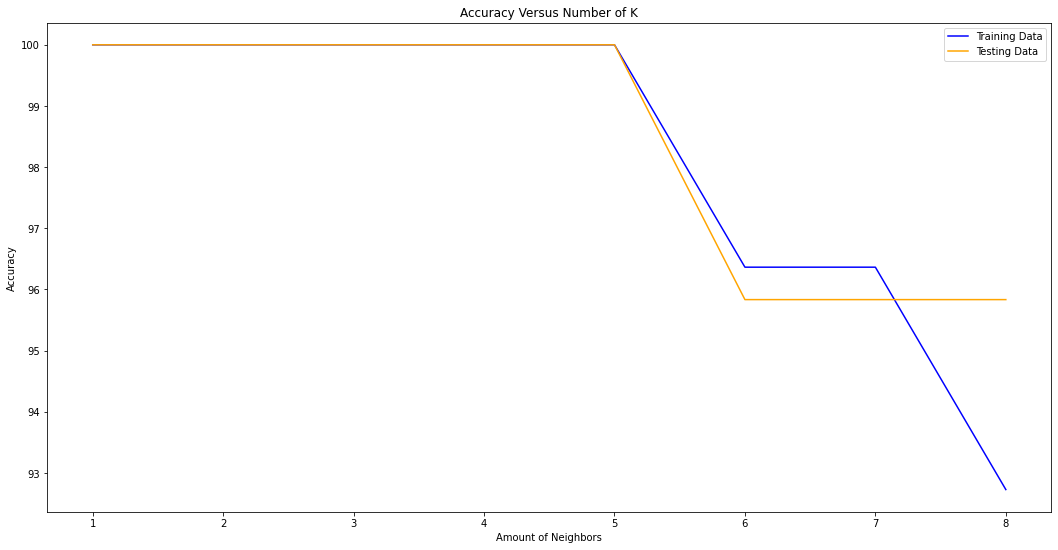

Accuracy on training 1.000
Accuracy on testing 0.917
Number of Leaves 2
Tree Depth 1


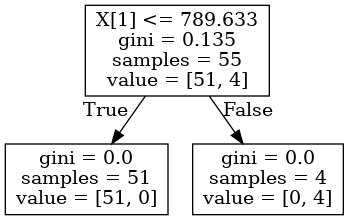

Prune Level: 5
Accuracy on training 0.927
Accuracy on testing 0.958
Number of Leaves 3
Tree Depth 1


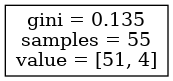

Prune Level: 30
Accuracy on training 0.927
Accuracy on testing 0.958
Number of Leaves 3
Tree Depth 1


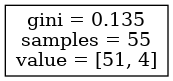

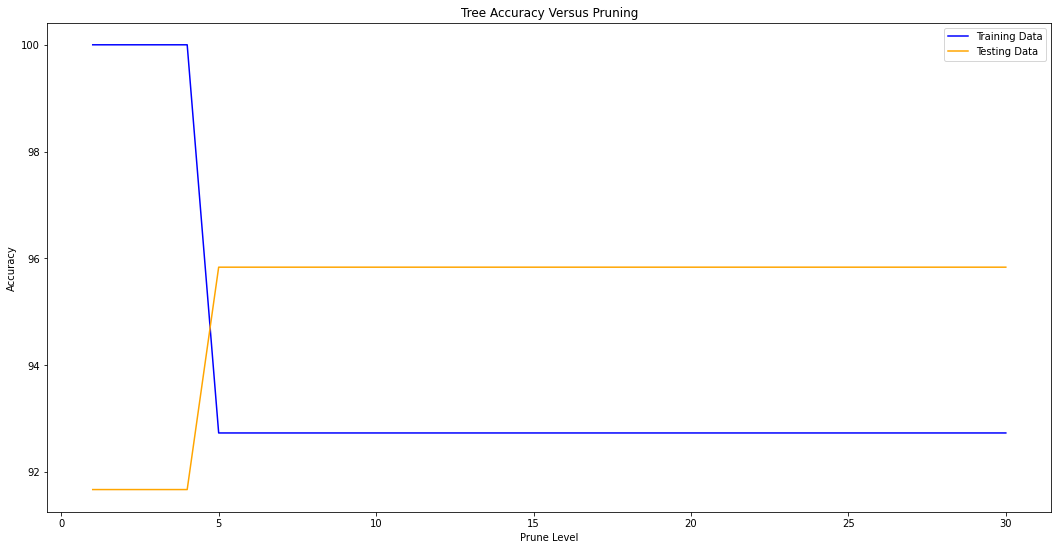

Error on training 0.000
Error on testing 0.083



In [10]:
from sklearn.naive_bayes import GaussianNB;
# Problem 6
print(temp)
x_train, x_test, y_train, y_test = train_test_split(temp.drop("clusters", axis=1),temp['clusters'], random_state=42, test_size=.30 )

# K-nearest Neighbor

iterations = 8
training_accuracy = []
testing_accuracy = []

for i in range(iterations):
    
    kN = KNeighborsClassifier(n_neighbors=i+1)
    kN.fit(x_train, y_train)
    training_accuracy.append(kN.score(x_train,y_train))
    testing_accuracy.append(kN.score(x_test,y_test))
    
    
    if i ==0:
        continue
    if kN.score(x_test,y_test) > max(testing_accuracy[:i]):
        print("KNearest Neighbor\n{} Neighbors".format(i+1))
        print("Accuracy on training {:.3f}".format(kN.score(x_train,y_train)))
        print("Accuracy on testing {:.3f}".format(kN.score(x_test,y_test)))
    
# print("KNearest Neighbor\n{} Neighbors".format(i+1))
print("Accuracy on training {:.3f}".format(max(testing_accuracy[:5])))
print("Accuracy on testing {:.3f}".format(max(testing_accuracy[:5])))
plt.plot(np.add(range(iterations),1), np.multiply(training_accuracy,100), c='blue', label='Training Data')
plt.plot(np.add(range(iterations),1), np.multiply(testing_accuracy,100), c='orange', label="Testing Data")
plt.xlabel("Amount of Neighbors")
plt.ylabel("Accuracy")
plt.title("Accuracy Versus Number of K")
plt.legend()
plt.show()

# Decision Trees
tree = DecisionTreeClassifier(random_state=0)
tree.fit(x_train, y_train)

print("Accuracy on training {:.3f}".format(tree.score(x_train,y_train)))
print("Accuracy on testing {:.3f}".format(tree.score(x_test,y_test)))
print("Number of Leaves {}".format(tree.get_n_leaves()))
print("Tree Depth {}".format(tree.get_depth()))

dot_data = treeDep.export_graphviz(tree, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
# graph.write_png('./tree.png')
display(Image(graph.create_png()))

# Prune
levels = 30
training_accuracy = []
testing_accuracy = []
for i in range(levels):
    
    DataProcessing.prune_index(tree.tree_, 0, i+1)
    training_accuracy.append(tree.score(x_train,y_train))
    testing_accuracy.append(tree.score(x_test,y_test))
    if i ==0:
        continue
    if tree.score(x_test,y_test) > max(testing_accuracy[:i]) or i == levels-1:
        print("Prune Level: {}".format(i+1))
        print("Accuracy on training {:.3f}".format(tree.score(x_train,y_train)))
        print("Accuracy on testing {:.3f}".format(tree.score(x_test,y_test)))
        print("Number of Leaves {}".format(tree.get_n_leaves()))
        print("Tree Depth {}".format(tree.get_depth()))

        dot_data = treeDep.export_graphviz(tree, out_file=None)
        graph = pydotplus.graph_from_dot_data(dot_data)
        # graph.write_png('./treepruned.png')
        display(Image(graph.create_png()))

plt.plot(np.add(range(levels),1), np.multiply(training_accuracy,100), c='blue', label='Training Data')
plt.plot(np.add(range(levels),1), np.multiply(testing_accuracy,100), c='orange', label="Testing Data")
plt.xlabel("Prune Level")
plt.ylabel("Accuracy")
plt.title("Tree Accuracy Versus Pruning")
plt.legend()
plt.show()




Naive Bayes
 Distribution 2
Accuracy on training 1.000
Accuracy on testing 0.958
Naive Bayes
 Distribution 3
Accuracy on training 1.000
Accuracy on testing 1.000


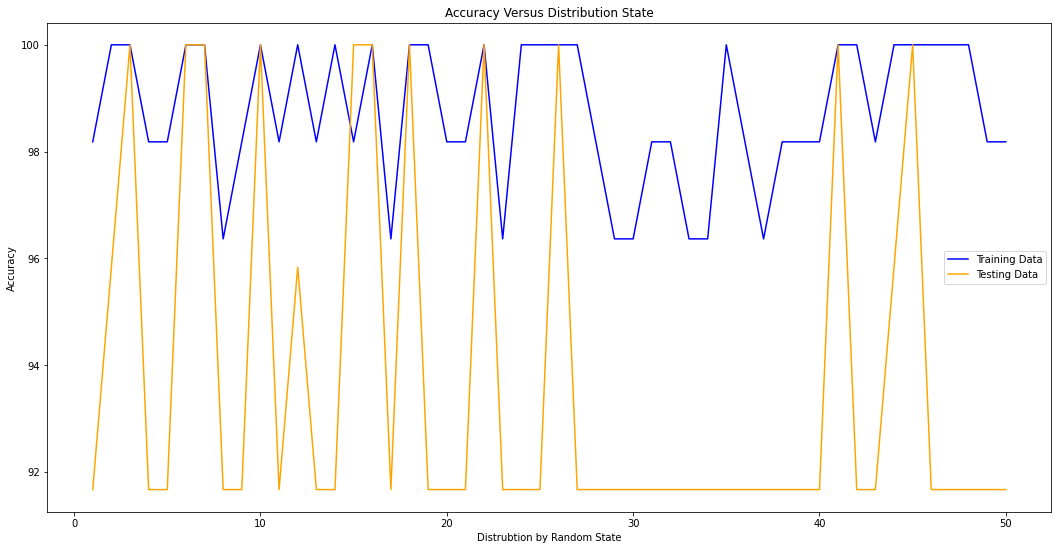

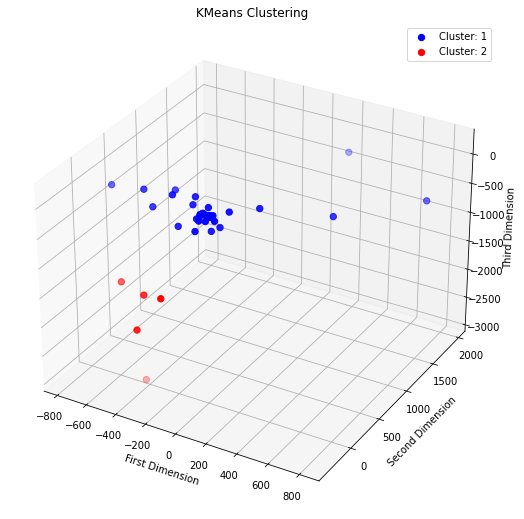

In [19]:
# Run Naive Bayes with different distributions

# Run MDS on the data

unique_areas_reduced = dict.fromkeys(norm_FAO['Area']).keys()

states = 50
mds_array=[]

for i in range(states):
    focused_data = norm_FAO.drop('Area', axis=1)
    emb = MDS(3, random_state=i)
    fitted_x = emb.fit_transform(focused_data.values)
    mds_array.append(fitted_x)    

training_accuracy = []
testing_accuracy = []

# Run KMeans on the data
large_frame = pd.DataFrame(columns = ["First","Second","Third", "clusters"])

headers = list(dict_cereals.keys())
headers.append("clusters")
PC1 = pd.DataFrame(columns = headers)
PC2 = pd.DataFrame(columns = headers)
PC3 = pd.DataFrame(columns = headers)

for i in range(len(mds_array)):

    focused_data = mds_array[i]
    kmeans = KMeans(n_clusters=2, random_state=54)
    yhat = kmeans.fit_predict(focused_data)
    temp = focused_data
    temp = pd.DataFrame(temp,columns=["First","Second","Third"])
    temp['clusters'] = yhat

    df1 = temp[temp['clusters']==0]
    df2 = temp[temp['clusters']==1]
    
    large_frame=large_frame.append(temp, ignore_index=True)
    
    # Naive Bayes
    x_train, x_test, y_train, y_test = train_test_split(temp.drop("clusters", axis=1),temp['clusters'], random_state=42, test_size=.30 )
    mdl = GaussianNB()
    mdl.fit(x_train, y_train)
    training_accuracy.append(mdl.score(x_train,y_train))
    testing_accuracy.append(mdl.score(x_test,y_test))
    
    if i ==0:
        continue
    if mdl.score(x_test,y_test) > max(testing_accuracy[:i]):
        print("Naive Bayes\n Distribution {}".format(i+1))
        print("Accuracy on training {:.3f}".format(mdl.score(x_train,y_train)))
        print("Accuracy on testing {:.3f}".format(mdl.score(x_test,y_test)))
        savedx1 = df1
        savedx2 = df2
        
#     errRateNBTrain = 1 - mdl.score(x_train,y_train)
#     errRateNBTest = 1 - mdl.score(x_test,y_test)
    
    
#     print("Error on training {:.3f}".format(errRateNBTrain))
#     print("Error on testing {:.3f}\n".format(errRateNBTest))

plt.plot(np.add(range(len(mds_array)),1), np.multiply(training_accuracy,100), c='blue', label='Training Data')
plt.plot(np.add(range(len(mds_array)),1), np.multiply(testing_accuracy,100), c='orange', label="Testing Data")
plt.xlabel("Distrubtion by Random State")
plt.ylabel("Accuracy")
plt.title("Accuracy Versus Distribution State")
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(savedx1['First'],savedx1['Second'],savedx1['Third'],c="blue", s=40, label = 'Normal Yield')
ax.scatter(savedx2['First'],savedx2['Second'],savedx2['Third'],c="red", s=40, label = 'Low Yield')
plt.legend()
ax.set_xlabel("First Dimension")
ax.set_ylabel("Second Dimension")
ax.set_zlabel("Third Dimension")
plt.title("KMeans Clustering")
plt.show()  